In [1]:
import pandas as pd
import cupy as cp
import cubewalkers as cw
import matplotlib.pyplot as plt
from matplotlib.colors import CenteredNorm
from matplotlib.patches import Rectangle
%matplotlib inline

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999
plt.rcParams.update({'font.size':20})

In [2]:
QCF = pd.read_csv('data/quasicoherence_fuzzy_withsource.csv')
QCN = pd.read_csv('data/quasicoherence_nonfuzzy_withsource.csv')
QCFNS = pd.read_csv('data/quasicoherence_fuzzy_sourceless.csv')
QCNS = pd.read_csv('data/quasicoherence_nonfuzzy_sourceless.csv')
FHD = pd.read_csv('data/final_hamming_distance_withsource.csv')
FHDNS = pd.read_csv('data/final_hamming_distance_sourceless.csv')
DC = pd.read_csv('data/derrida_coefficients.csv')
QC = pd.read_csv('data/model_categories.csv')
QC = QC.merge(QCN)
QC = QC.merge(QCF)
QC = QC.merge(QCNS)
QC = QC.merge(QCFNS)
QC = QC.merge(FHD)
QC = QC.merge(FHDNS)
QC = QC.merge(DC)
QC.columns = ['name', 'category',
              'SQC', 'AQC', 
              'SFQC', 'AFQC', 
              'SQCNS', 'AQCNS', 
              'SFQCNS', 'AFQCNS',
              'SFHD', 'AFHD', 
              'SFHDNS', 'AFHDNS',
              'SDC', 'ADC', 
              'SDCNS', 'ADCNS']



N = []
NS = []
for name in sorted(QC['name']):
    with open(f'models/cell_collective/{name}.txt') as f:
        nt = 0
        ns = 0
        for row in f:
            nt += 1
            if row.split(',')[0].strip() == row.split(',')[1].strip():
                ns += 1
        N.append(nt)
        NS.append(ns)

NDF = pd.DataFrame({
    'name': sorted(QC['name']),
    'N': N,
    'NS': NS,
})

QC=QC.merge(NDF)

# Fragility = 
# long-term difference in node avg. values after initial 1-node perturbation
QC['AF'] = (1-QC['AFQC'])*(QC['N'])
QC['SF'] = (1-QC['SFQC'])*(QC['N'])
QC['AFNS'] = (1-QC['AFQCNS'])*(QC['N']-QC['NS'])
QC['SFNS'] = (1-QC['SFQCNS'])*(QC['N']-QC['NS'])

QC.sort_values(by=['name'])

,name,category,SQC,AQC,SFQC,AFQC,SQCNS,AQCNS,SFQCNS,AFQCNS,SFHD,AFHD,SFHDNS,AFHDNS,SDC,ADC,SDCNS,ADCNS,N,NS,AF,SF,AFNS,SFNS
0,Apoptosis Network,Signal Transduction (Stress/Damage and Homeost...,0.903063,0.911766,0.975734,0.976564,0.949374,0.958523,0.989265,0.991469,1.433632,1.119603,0.811839,0.461110,1.00488,1.037920,0.928257,0.957248,41,2,0.960876,0.994906,0.332709,0.418665
1,Arabidopsis thaliana Cell Cycle,Cell Cycle,1.000000,1.000000,0.999986,1.000000,1.000000,1.000000,0.999986,1.000000,1.732337,0.000000,1.732337,0.000000,1.27225,1.215076,1.271043,1.227097,14,0,0.000000,0.000196,0.000000,0.000196
2,Aurora Kinase A in Neuroblastoma,Cancer,0.761200,0.778609,0.943288,0.941871,0.921453,0.942526,0.958815,0.953696,1.825235,1.337004,1.357291,0.879826,1.04819,1.063182,0.991720,0.999190,23,4,1.336967,1.304376,0.879776,0.782515
3,B bronchiseptica and T retortaeformis coinfection,Infection and Microbiome,0.911064,0.925494,0.991302,0.988368,0.928585,0.943292,0.992855,0.990268,0.464348,0.616483,0.374940,0.506085,1.00127,0.996849,0.966009,0.967529,53,1,0.616496,0.460994,0.506064,0.371540
4,B cell differentiation,Development and Differentiation,0.736564,0.739491,0.957846,0.955954,0.953200,0.956988,0.986464,0.987694,0.927391,0.969018,0.230118,0.209200,0.99674,1.019382,0.704322,0.747895,22,5,0.969012,0.927388,0.209202,0.230112
7,BT474 Breast Cell Line Long-term ErbB Network,Cancer Drug Response,0.622832,0.605360,0.973295,0.971707,0.819516,0.796526,0.985526,0.983151,0.667616,0.707328,0.275011,0.320126,0.94772,0.922200,0.803044,0.794584,25,6,0.707325,0.667625,0.320131,0.275006
8,BT474 Breast Cell Line Short-term ErbB Network,Cancer Drug Response,0.641475,0.602025,0.964380,0.958502,0.933055,0.875673,0.989379,0.982869,0.569925,0.663975,0.116836,0.188436,0.76086,0.826380,0.374177,0.553145,16,5,0.663968,0.569920,0.188441,0.116831
5,Bordetella bronchiseptica,Infection and Microbiome,0.970642,0.966521,0.993765,0.998550,0.970642,0.966521,0.993765,0.998550,0.206618,0.047855,0.206618,0.047855,1.01878,0.990579,1.013961,0.999820,33,0,0.047850,0.205755,0.047850,0.205755
6,Bortezomib Responses in U266 Human Myeloma Cells,Cancer Drug Response,0.924615,0.920203,0.991630,0.988959,0.999181,0.994413,0.999562,0.996934,0.560776,0.739737,0.027134,0.190103,0.97716,1.008713,0.898823,0.935004,67,5,0.739747,0.560790,0.190092,0.027156
10,Budding Yeast Cell Cycle,Cell Cycle,0.721320,0.781560,0.952011,0.953503,0.901650,0.976950,0.986100,0.992657,1.060696,0.929999,0.332186,0.117573,1.01413,1.019960,0.825870,0.865000,20,4,0.929940,0.959780,0.117488,0.222400


In [103]:
highlight_marker_size = 350
highlight_alpha = 1

color_list = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#DDDDDD'] # tol_muted scheme

highlight_dict = {
    'Apoptosis Network':(color_list[0],highlight_marker_size,highlight_alpha),
    'Arabidopsis thaliana Cell Cycle':(color_list[1],highlight_marker_size,highlight_alpha),
    'Aurora Kinase A in Neuroblastoma':(color_list[2],highlight_marker_size,highlight_alpha),
    'Colitis-associated colon cancer': (color_list[5],highlight_marker_size,highlight_alpha),
    'Cortical Area Development':(color_list[4],highlight_marker_size,highlight_alpha),
    'Human Gonadal Sex Determination': (color_list[3],highlight_marker_size,highlight_alpha),
    'Metabolic Interactions in the Gut Microbiome':(color_list[6],highlight_marker_size,highlight_alpha),
    'Regulation of the L-arabinose operon of Escherichia coli':(color_list[7],highlight_marker_size,highlight_alpha),
    'Tumour Cell Invasion and Migration': (color_list[8],highlight_marker_size,highlight_alpha),
}
default_highlight = ('black',250,0.2)

category_symbol_dict = {
    'Cancer': 'X',
    'Cancer Drug Response': 'P',
    'Cell Cycle': 'o',
    'Development and Differentiation': 'd',
    'Infection and Microbiome': 'p',
    'Metabolism': 'H',
    'Signal Transduction (Immune System Cells)': '^',
    'Signal Transduction (Other)': 'v',
    'Signal Transduction (Drosophila)': '>',
    'Signal Transduction (Stress/Damage and Homeostasis)': '<',
}

def hc(df):
    return [highlight_dict.get(name, default_highlight)[0] for name in df['name']]
def hs(df):
    return [highlight_dict.get(name, default_highlight)[1] for name in df['name']]
def halpha(df):
    return [highlight_dict.get(name, default_highlight)[2] for name in df['name']]

groups = QC.groupby('category')

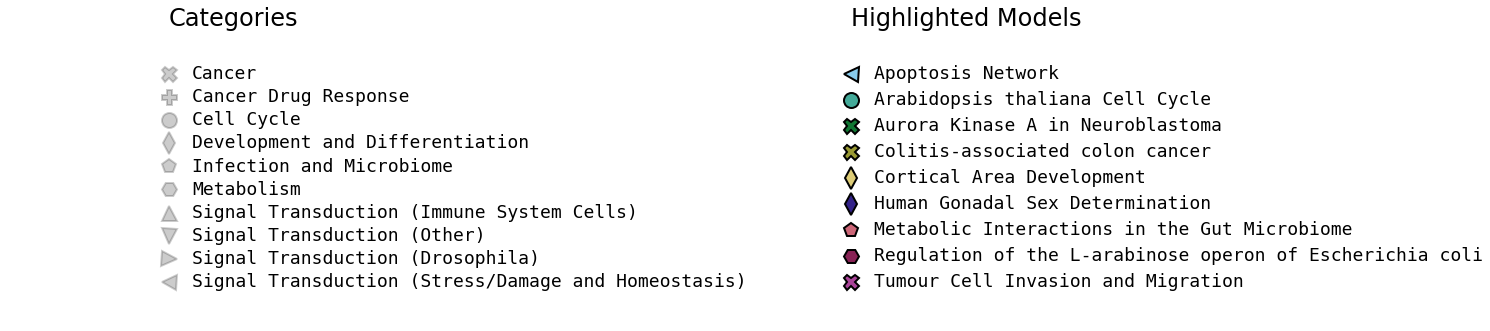

In [105]:
text_style = dict(horizontalalignment='left', verticalalignment='center',
                  fontsize=18, fontfamily='monospace')
marker_style = dict(linestyle=':', markersize=15)


def format_axes(ax):
    ax.margins(0.2)
    ax.set_axis_off()
    ax.invert_yaxis()
    
fig,ax = plt.subplots(1,2,figsize=(20,5))
fig.set_facecolor('white')
# fig.suptitle('Shared Legend', fontsize=24)
# fig.subplots_adjust(right=-4,left=-5)

for y, (name, marker) in enumerate(category_symbol_dict.items()):
    ax[0].text(0.01, y, name, **text_style)
    ax[0].plot([y] * 1, c=default_highlight[0],alpha=default_highlight[2], marker=marker,markeredgewidth=2,markeredgecolor='k', **marker_style)
for y, (name, marker_data) in enumerate(highlight_dict.items()):
    ax[1].text(0.01, y, name, **text_style)
    ax[1].plot([y] * 1, c=marker_data[0], alpha=marker_data[2], marker=category_symbol_dict[QC[QC['name']==name]['category'].values[0]],markeredgewidth=2,markeredgecolor='k', **marker_style)
ax[0].set_title('Categories',horizontalalignment='left')
ax[1].set_title('Highlighted Models',horizontalalignment='left')
format_axes(ax[0])
format_axes(ax[1])

fig.tight_layout()
plt.savefig('./figures/shared_legend.png',bbox_inches='tight')
plt.savefig('./figures/shared_legend.pdf',bbox_inches='tight')
plt.show()

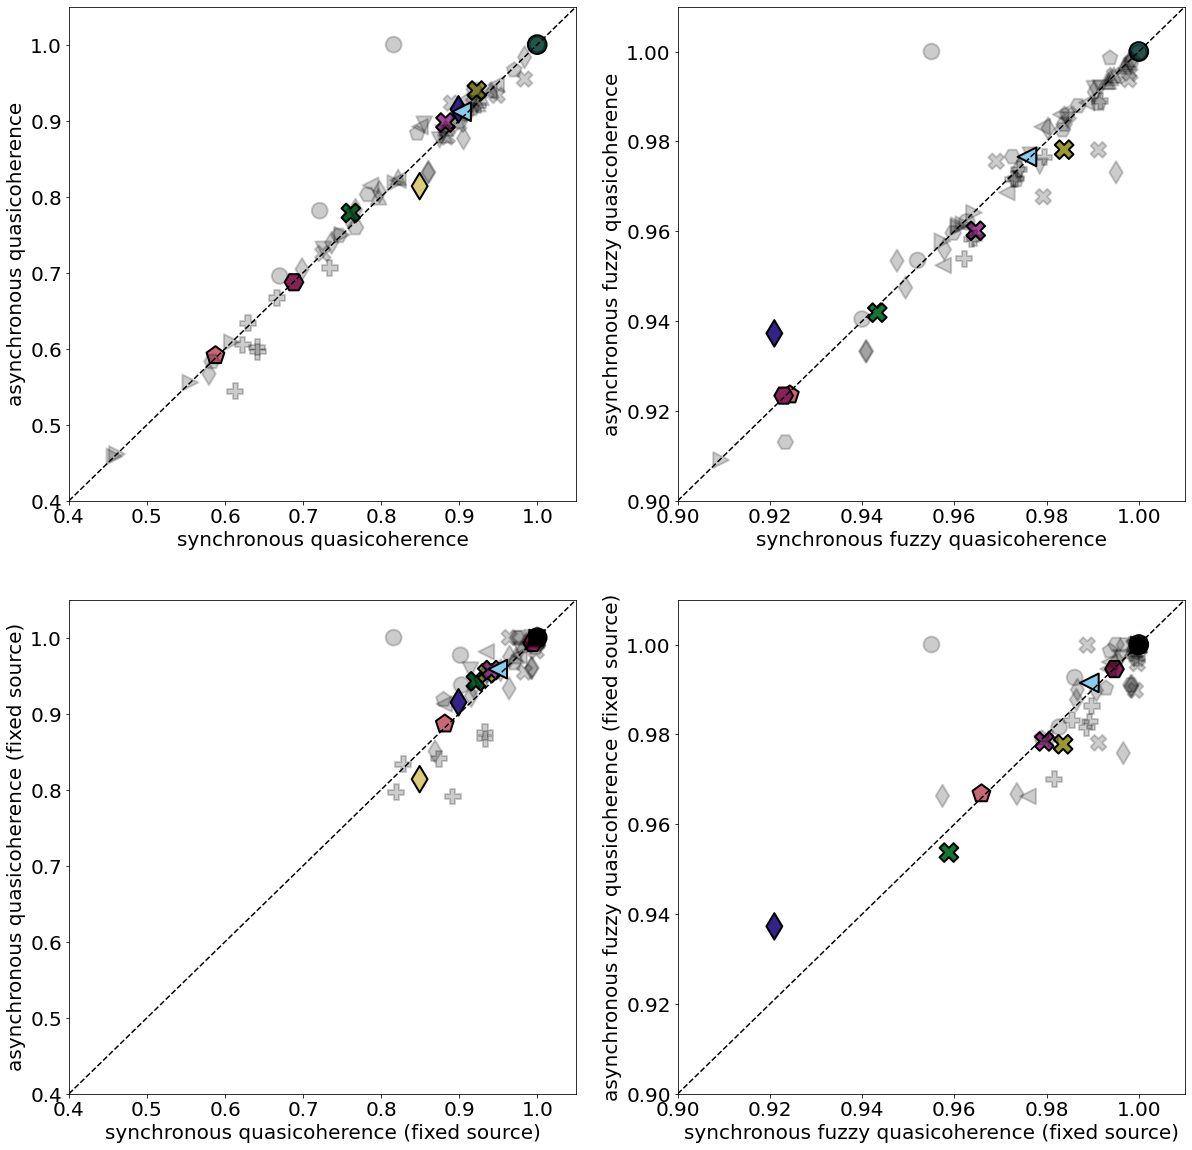

In [106]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')
for name,group in groups:
    ax[0,0].scatter(group['SQC'],group['AQC'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
ax[0,0].set_xlabel('synchronous quasicoherence')
ax[0,0].set_ylabel('asynchronous quasicoherence')
ax[0,0].set_xlim(0.4,1.05)
ax[0,0].set_ylim(0.4,1.05)

for name,group in groups:
    ax[0,1].scatter(group['SFQC'],group['AFQC'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,1].scatter(QC['SFQC'],QC['AFQC'])
ax[0,1].set_xlabel('synchronous fuzzy quasicoherence')
ax[0,1].set_ylabel('asynchronous fuzzy quasicoherence')
ax[0,1].set_xlim(0.9,1.01)
ax[0,1].set_ylim(0.9,1.01)

for name,group in groups:
    ax[1,0].scatter(group['SQCNS'],group['AQCNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,0].scatter(QC['SQCNS'],QC['AQCNS'])
ax[1,0].set_xlabel('synchronous quasicoherence (fixed source)')
ax[1,0].set_ylabel('asynchronous quasicoherence (fixed source)')
ax[1,0].set_xlim(0.4,1.05)
ax[1,0].set_ylim(0.4,1.05)

for name,group in groups:
    ax[1,1].scatter(group['SFQCNS'],group['AFQCNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,1].scatter(QC['SFQCNS'],QC['AFQCNS'])
ax[1,1].set_xlabel('synchronous fuzzy quasicoherence (fixed source)')
ax[1,1].set_ylabel('asynchronous fuzzy quasicoherence (fixed source)')
ax[1,1].set_xlim(0.9,1.01)
ax[1,1].set_ylim(0.9,1.01)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')

plt.savefig('./figures/quasicoherence_comparisons.png')
plt.savefig('./figures/quasicoherence_comparisons.pdf')
plt.show()

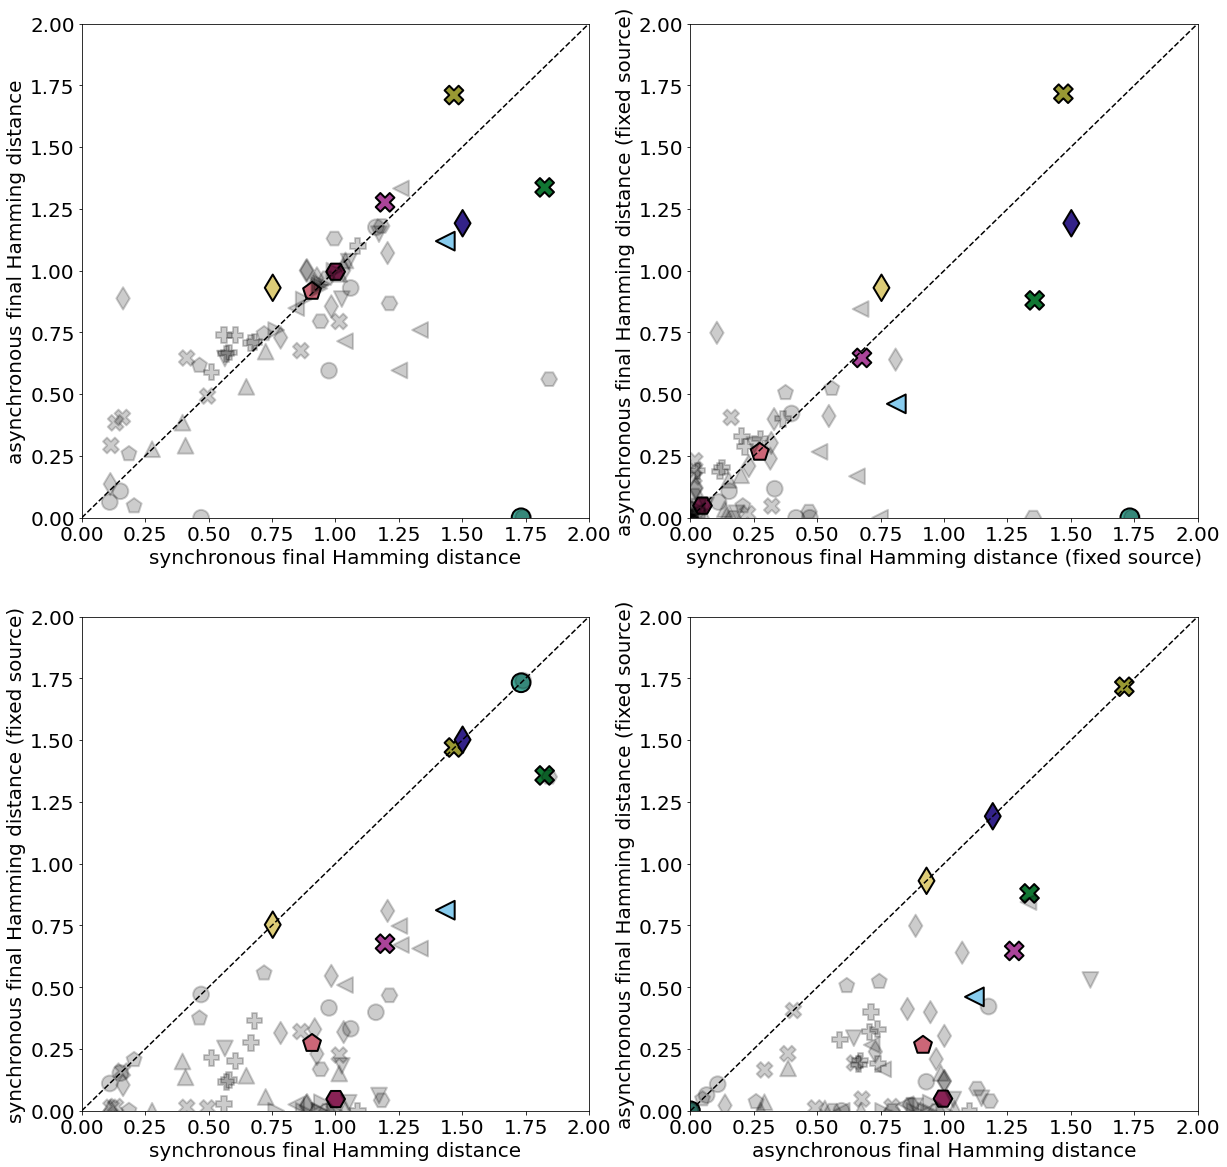

In [107]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

for name,group in groups:
    ax[0,0].scatter(group['SFHD'],group['AFHD'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,0].scatter(QC['SFHD'],QC['AFHD'])
ax[0,0].set_xlabel('synchronous final Hamming distance')
ax[0,0].set_ylabel('asynchronous final Hamming distance')
ax[0,0].set_xlim(0,2)
ax[0,0].set_ylim(0,2)

for name,group in groups:
    ax[0,1].scatter(group['SFHDNS'],group['AFHDNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,1].scatter(QC['SFHDNS'],QC['AFHDNS'])
ax[0,1].set_xlabel('synchronous final Hamming distance (fixed source)')
ax[0,1].set_ylabel('asynchronous final Hamming distance (fixed source)')
ax[0,1].set_xlim(0,2)
ax[0,1].set_ylim(0,2)

for name,group in groups:
    ax[1,0].scatter(group['SFHD'],group['SFHDNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,0].scatter(QC['SFHD'],QC['SFHDNS'])
ax[1,0].set_xlabel('synchronous final Hamming distance')
ax[1,0].set_ylabel('synchronous final Hamming distance (fixed source)')
ax[1,0].set_xlim(0,2)
ax[1,0].set_ylim(0,2)

for name,group in groups:
    ax[1,1].scatter(group['AFHD'],group['AFHDNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,1].scatter(QC['AFHD'],QC['AFHDNS'])
ax[1,1].set_xlabel('asynchronous final Hamming distance')
ax[1,1].set_ylabel('asynchronous final Hamming distance (fixed source)')
ax[1,1].set_xlim(0,2)
ax[1,1].set_ylim(0,2)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')


plt.savefig('./figures/Hamming_comparison.png')
plt.savefig('./figures/Hamming_comparison.pdf')
plt.show()

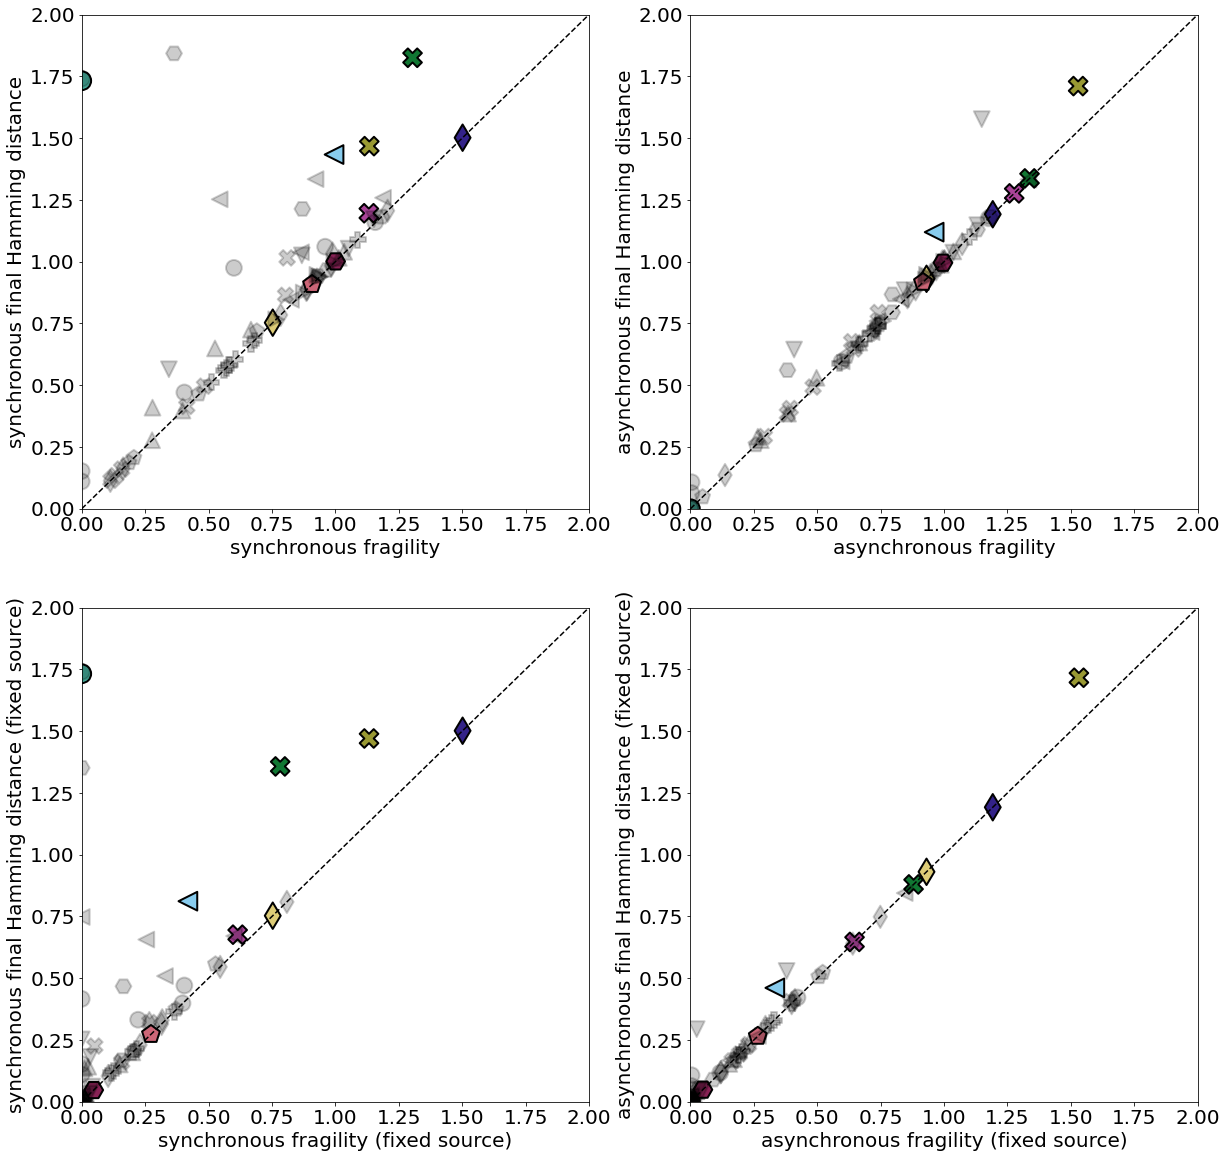

In [108]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

for name,group in groups:
    ax[0,0].scatter(group['SF'],group['SFHD'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,0].scatter(QC['SF'],QC['SFHD'])
ax[0,0].set_xlabel('synchronous fragility')
ax[0,0].set_ylabel('synchronous final Hamming distance')
ax[0,0].set_xlim(0,2)
ax[0,0].set_ylim(0,2)

for name,group in groups:
    ax[0,1].scatter(group['AF'],group['AFHD'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,1].scatter(QC['AF'],QC['AFHD'])
ax[0,1].set_xlabel('asynchronous fragility')
ax[0,1].set_ylabel('asynchronous final Hamming distance')
ax[0,1].set_xlim(0,2)
ax[0,1].set_ylim(0,2)

for name,group in groups:
    ax[1,0].scatter(group['SFNS'],group['SFHDNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,0].scatter(QC['SFNS'],QC['SFHDNS'])
ax[1,0].set_xlabel('synchronous fragility (fixed source)')
ax[1,0].set_ylabel('synchronous final Hamming distance (fixed source)')
ax[1,0].set_xlim(0,2)
ax[1,0].set_ylim(0,2)

for name,group in groups:
    ax[1,1].scatter(group['AFNS'],group['AFHDNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,1].scatter(QC['AFNS'],QC['AFHDNS'])
ax[1,1].set_xlabel('asynchronous fragility (fixed source)')
ax[1,1].set_ylabel('asynchronous final Hamming distance (fixed source)')
ax[1,1].set_xlim(0,2)
ax[1,1].set_ylim(0,2)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')

plt.savefig('./figures/Hamming-Fragility.png')
plt.savefig('./figures/Hamming-Fragility.pdf')
plt.show()

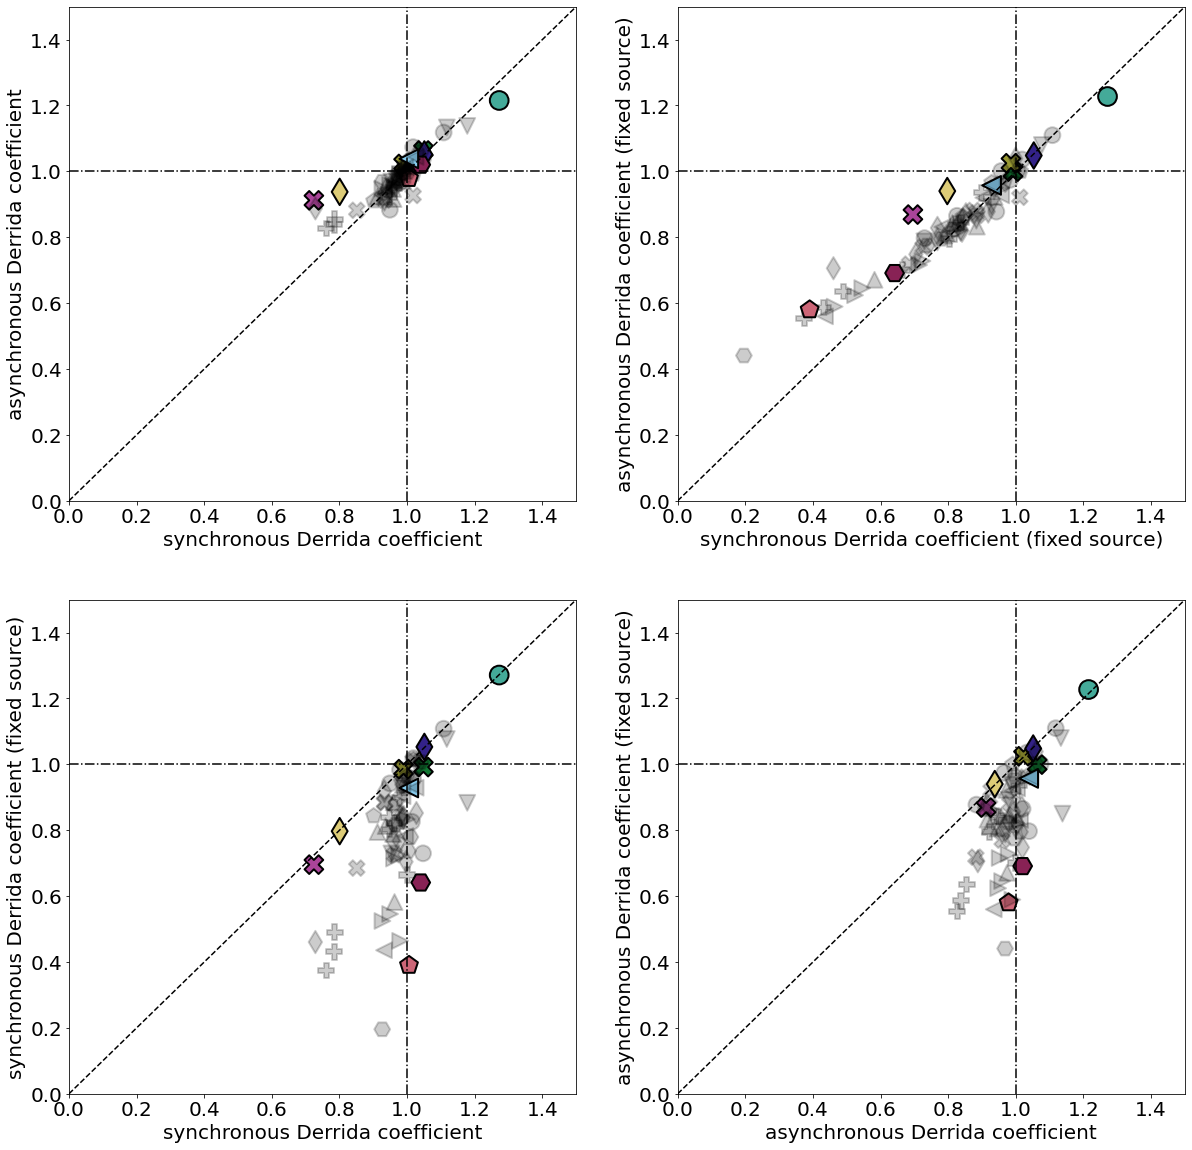

In [109]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

for name,group in groups:
    ax[0,0].scatter(group['SDC'],group['ADC'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,0].scatter(QC['SDC'],QC['ADC'])
ax[0,0].set_xlabel('synchronous Derrida coefficient')
ax[0,0].set_ylabel('asynchronous Derrida coefficient')
ax[0,0].set_xlim(0,1.5)
ax[0,0].set_ylim(0,1.5)

for name,group in groups:
    ax[0,1].scatter(group['SDCNS'],group['ADCNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,1].scatter(QC['SDCNS'],QC['ADCNS'])
ax[0,1].set_xlabel('synchronous Derrida coefficient (fixed source)')
ax[0,1].set_ylabel('asynchronous Derrida coefficient (fixed source)')
ax[0,1].set_xlim(0,1.5)
ax[0,1].set_ylim(0,1.5)

for name,group in groups:
    ax[1,0].scatter(group['SDC'],group['SDCNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,0].scatter(QC['SDC'],QC['SDCNS'])
ax[1,0].set_xlabel('synchronous Derrida coefficient')
ax[1,0].set_ylabel('synchronous Derrida coefficient (fixed source)')
ax[1,0].set_xlim(0,1.5)
ax[1,0].set_ylim(0,1.5)

for name,group in groups:
    ax[1,1].scatter(group['ADC'],group['ADCNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,1].scatter(QC['ADC'],QC['ADCNS'])
ax[1,1].set_xlabel('asynchronous Derrida coefficient')
ax[1,1].set_ylabel('asynchronous Derrida coefficient (fixed source)')
ax[1,1].set_xlim(0,1.5)
ax[1,1].set_ylim(0,1.5)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')
    sub_ax.hlines(1,0,1.5,linestyle='-.',color='k')
    sub_ax.vlines(1,0,1.5,linestyle='-.',color='k')

plt.savefig('./figures/Derrida_comparison.png')
plt.savefig('./figures/Derrida_comparison.pdf')
plt.show()

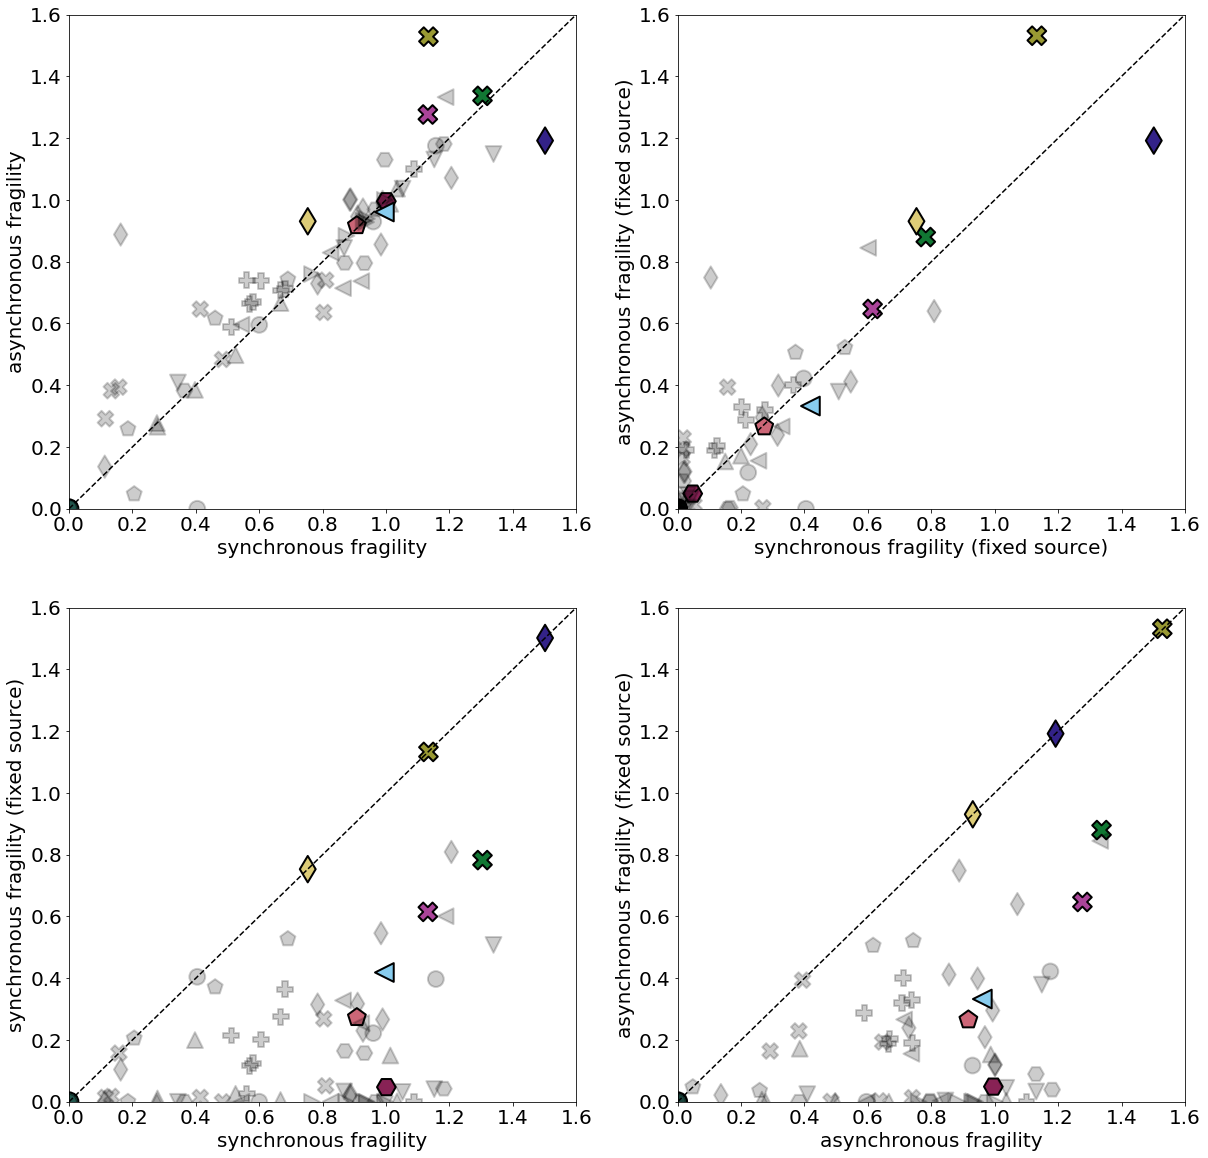

In [110]:
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

for name,group in groups:
    ax[0,0].scatter(group['SF'],group['AF'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,0].scatter(QC['SF'],QC['AF'])
ax[0,0].set_xlabel('synchronous fragility')
ax[0,0].set_ylabel('asynchronous fragility')
ax[0,0].set_xlim(0,1.6)
ax[0,0].set_ylim(0,1.6)

for name,group in groups:
    ax[0,1].scatter(group['SFNS'],group['AFNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,1].scatter(QC['SFNS'],QC['AFNS'])
ax[0,1].set_xlabel('synchronous fragility (fixed source)')
ax[0,1].set_ylabel('asynchronous fragility (fixed source)')
ax[0,1].set_xlim(0,1.6)
ax[0,1].set_ylim(0,1.6)

for name,group in groups:
    ax[1,0].scatter(group['SF'],group['SFNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,0].scatter(QC['SF'],QC['SFNS'])
ax[1,0].set_xlabel('synchronous fragility')
ax[1,0].set_ylabel('synchronous fragility (fixed source)')
ax[1,0].set_xlim(0,1.6)
ax[1,0].set_ylim(0,1.6)

for name,group in groups:
    ax[1,1].scatter(group['AF'],group['AFNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,1].scatter(QC['AF'],QC['AFNS'])
ax[1,1].set_xlabel('asynchronous fragility')
ax[1,1].set_ylabel('asynchronous fragility (fixed source)')
ax[1,1].set_xlim(0,1.6)
ax[1,1].set_ylim(0,1.6)

for sub_ax in ax.flatten():
    sub_ax.axline((1,1),slope=1,linestyle='--',color='k')

plt.savefig('./figures/fragility_comparison.png')
plt.savefig('./figures/fragility_comparison.pdf')
plt.show()

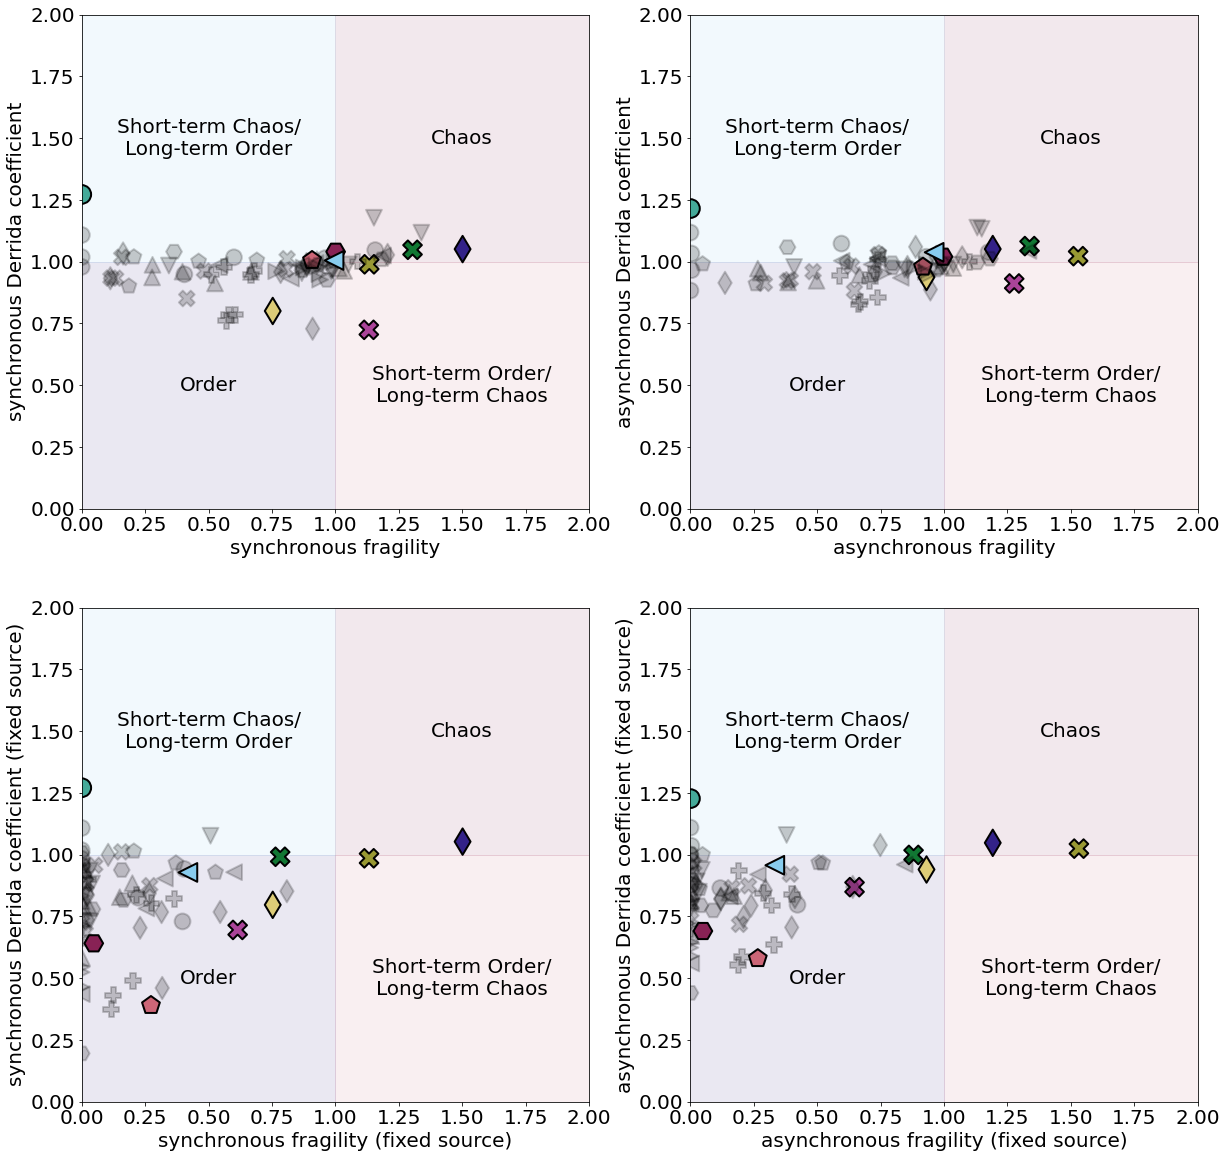

In [111]:
region_alpha = 0.1
cmap = plt.cm.get_cmap('coolwarm')
maxval = 2.0
cnorm=CenteredNorm(vcenter=0,halfrange=0.5)
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

for sub_ax in ax.flatten():
    # color_list = ['#88CCEE', '#44AA99', '#117733', '#332288', '#DDCC77', '#999933','#CC6677', '#882255', '#AA4499', '#DDDDDD'] # tol_muted scheme
    regions = [
        Rectangle((0,0),1,1,color='#332288',alpha=region_alpha),
        Rectangle((1,1),maxval-1,maxval-1,color='#882255',alpha=region_alpha),
        Rectangle((0,1),1,maxval-1,color='#88CCEE',alpha=region_alpha),
        Rectangle((1,0),maxval-1,1,color='#CC6677',alpha=region_alpha),
        ]
    
    #sub_ax.axline((1,1),slope=1,linestyle='--',color='k')
    # sub_ax.hlines(1,0,maxval,linestyle='-.',color='k')
    # sub_ax.vlines(1,0,maxval,linestyle='-.',color='k')
    [sub_ax.add_patch(r) for r in regions]
    sub_ax.annotate('Short-term Chaos/\nLong-term Order',xy=(0.5,1.5),ha='center',va='center')
    sub_ax.annotate('Order',xy=(0.5,0.5),ha='center',va='center')
    sub_ax.annotate('Short-term Order/\nLong-term Chaos',xy=(1.5,0.5),ha='center',va='center')
    sub_ax.annotate('Chaos',xy=(1.5,1.5),ha='center',va='center')
for name,group in groups:
    ax[0,0].scatter(group['SF'],group['SDC'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,0].scatter(QC['SF'],QC['SDC'],c='k')#c=QC['SF']-QC['SDC'],cmap=cmap, norm=cnorm)
ax[0,0].set_xlabel('synchronous fragility')
ax[0,0].set_ylabel('synchronous Derrida coefficient')
ax[0,0].set_xlim(0,maxval)
ax[0,0].set_ylim(0,maxval)

for name,group in groups:
    ax[0,1].scatter(group['AF'],group['ADC'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,1].scatter(QC['AF'],QC['ADC'],c='k')#c=QC['AF']-QC['ADC'],cmap=cmap, norm=cnorm)
ax[0,1].set_xlabel('asynchronous fragility')
ax[0,1].set_ylabel('asynchronous Derrida coefficient')
ax[0,1].set_xlim(0,maxval)
ax[0,1].set_ylim(0,maxval)

for name,group in groups:
    ax[1,0].scatter(group['SFNS'],group['SDCNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,0].scatter(QC['SFNS'],QC['SDCNS'], c='k')#c=QC['SFNS']-QC['SDCNS'],cmap=cmap, norm=cnorm)
ax[1,0].set_xlabel('synchronous fragility (fixed source)')
ax[1,0].set_ylabel('synchronous Derrida coefficient (fixed source)')
ax[1,0].set_xlim(0,maxval)
ax[1,0].set_ylim(0,maxval)

for name,group in groups:
    ax[1,1].scatter(group['AFNS'],group['ADCNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,1].scatter(QC['AFNS'],QC['ADCNS'],c='k')#c=QC['AFNS']-QC['ADCNS'],cmap=cmap, norm=cnorm)
ax[1,1].set_xlabel('asynchronous fragility (fixed source)')
ax[1,1].set_ylabel('asynchronous Derrida coefficient (fixed source)')
ax[1,1].set_xlim(0,maxval)
ax[1,1].set_ylim(0,maxval)



plt.savefig('./figures/Derrida-Fragility.png')
plt.savefig('./figures/Derrida-Fragility.pdf')
plt.show()

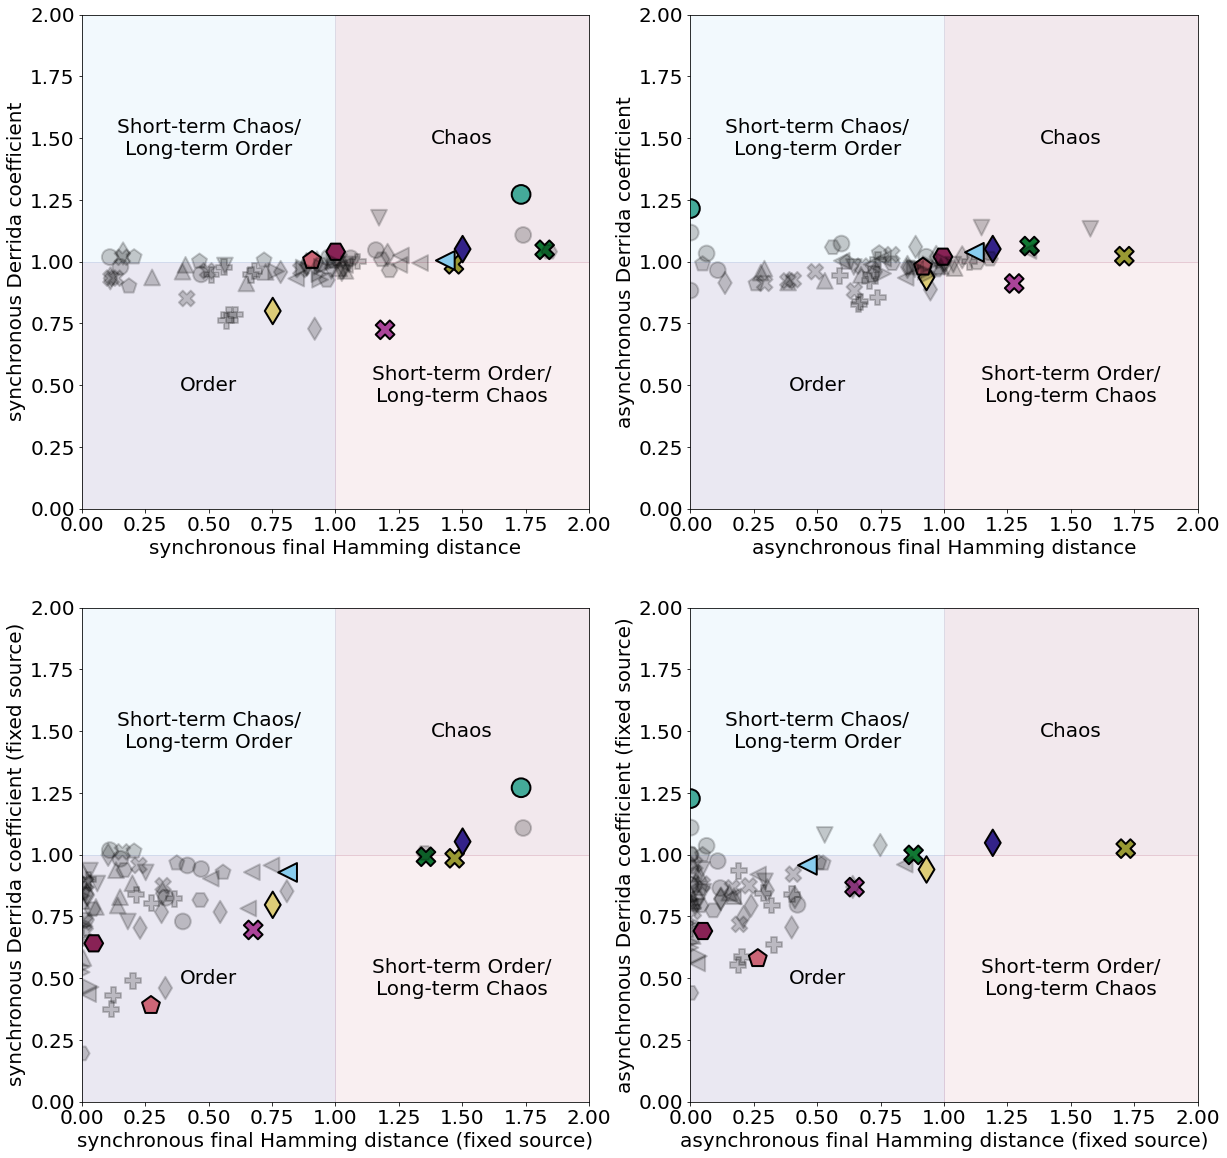

In [112]:
region_alpha = 0.1
cmap = plt.cm.get_cmap('coolwarm')
maxval = 2.0
cnorm=CenteredNorm(vcenter=0,halfrange=0.5)
fig,ax = plt.subplots(2,2,figsize=(20,20))
fig.set_facecolor('white')

for sub_ax in ax.flatten():
    regions = [
        Rectangle((0,0),1,1,color='#332288',alpha=region_alpha),
        Rectangle((1,1),maxval-1,maxval-1,color='#882255',alpha=region_alpha),
        Rectangle((0,1),1,maxval-1,color='#88CCEE',alpha=region_alpha),
        Rectangle((1,0),maxval-1,1,color='#CC6677',alpha=region_alpha),
        ]
    
    #sub_ax.axline((1,1),slope=1,linestyle='--',color='k')
    # sub_ax.hlines(1,0,maxval,linestyle='-.',color='k')
    # sub_ax.vlines(1,0,maxval,linestyle='-.',color='k')
    [sub_ax.add_patch(r) for r in regions]
    sub_ax.annotate('Short-term Chaos/\nLong-term Order',xy=(0.5,1.5),ha='center',va='center')
    sub_ax.annotate('Order',xy=(0.5,0.5),ha='center',va='center')
    sub_ax.annotate('Short-term Order/\nLong-term Chaos',xy=(1.5,0.5),ha='center',va='center')
    sub_ax.annotate('Chaos',xy=(1.5,1.5),ha='center',va='center')

for name,group in groups:
    ax[0,0].scatter(group['SFHD'],group['SDC'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,0].scatter(QC['SFHD'],QC['SDC'],c='k')#c=QC['SF']-QC['SDC'],cmap=cmap, norm=cnorm)
ax[0,0].set_xlabel('synchronous final Hamming distance')
ax[0,0].set_ylabel('synchronous Derrida coefficient')
ax[0,0].set_xlim(0,maxval)
ax[0,0].set_ylim(0,maxval)

for name,group in groups:
    ax[0,1].scatter(group['AFHD'],group['ADC'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[0,1].scatter(QC['AFHD'],QC['ADC'],c='k')#c=QC['AF']-QC['ADC'],cmap=cmap, norm=cnorm)
ax[0,1].set_xlabel('asynchronous final Hamming distance')
ax[0,1].set_ylabel('asynchronous Derrida coefficient')
ax[0,1].set_xlim(0,maxval)
ax[0,1].set_ylim(0,maxval)

for name,group in groups:
    ax[1,0].scatter(group['SFHDNS'],group['SDCNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,0].scatter(QC['SFHDNS'],QC['SDCNS'],c='k')#c=QC['SFNS']-QC['SDCNS'],cmap=cmap, norm=cnorm)
ax[1,0].set_xlabel('synchronous final Hamming distance (fixed source)')
ax[1,0].set_ylabel('synchronous Derrida coefficient (fixed source)')
ax[1,0].set_xlim(0,maxval)
ax[1,0].set_ylim(0,maxval)

for name,group in groups:
    ax[1,1].scatter(group['AFHDNS'],group['ADCNS'],c=hc(group),s=hs(group),alpha=halpha(group),marker=category_symbol_dict[name],linewidths=2,edgecolor='k')
# ax[1,1].scatter(QC['AFHDNS'],QC['ADCNS'],c='k')#c=QC['AFNS']-QC['ADCNS'],cmap=cmap, norm=cnorm)
ax[1,1].set_xlabel('asynchronous final Hamming distance (fixed source)')
ax[1,1].set_ylabel('asynchronous Derrida coefficient (fixed source)')
ax[1,1].set_xlim(0,maxval)
ax[1,1].set_ylim(0,maxval)



plt.savefig('./figures/Derrida-Hamming.png')
plt.savefig('./figures/Derrida-Hamming.pdf')
plt.show()